In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utility

from scipy import optimize, stats
%matplotlib inline

In [2]:
## Bioassay data

bioassay_data = pd.DataFrame({
    'x': [-0.86, -0.30, -0.05, 0.73],
    'n': [5, 5, 5, 5],
    'y': [0, 1, 3, 5]
})

In [3]:
## Generate the grid points and pairwise coordinates

x = np.linspace(-1.5, 7, 100)
y = np.linspace(-5, 35, 100)
alpha, beta = np.meshgrid(x, y) #100 x 100 meshgrids
coord = np.concatenate((alpha[..., np.newaxis], beta[..., np.newaxis]), axis=2) # pairwise coordinates of alpha and betta

In [4]:
## Optimize the negative log posterior to find parameters for normal approximation

w0 = np.array([0,0])
optim_res = optimize.minimize(utility.bioassayfun, w0, args=(bioassay_data,))
w = optim_res['x']
S = optim_res['hess_inv']

In [5]:
## Draw samples from the normal approximation

nsamp = 1000
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=nsamp)
Ar = samp_norm[:,0] 
Br = samp_norm[:,1]

In [6]:
## log likelihood and joint likelihood in the grid using the samples from normal approximation
# functions are in the utility.py script

# target distribution
lq = utility.logl(bioassay_data, Ar, Br) #lq = logl + logu but using a uniform prior
q = np.exp(lq)

In [7]:
## proposal distribution

g = stats.multivariate_normal.pdf(x=samp_norm, mean=w, cov=S)
M = np.max(q/g)
g = g * M

In [8]:
## Rejection Sampling

r = np.random.uniform(0, 1, nsamp) * g
acc = r < q # boolean values for this condition
samp_acc = samp_norm[acc, :] # get the accepted samples of (alpha,beta) only
samp_ld50 = - samp_acc[:, 0] / samp_acc[:, 1]

In [9]:
## relevant outputs

print('Alpha Mean: {}'.format(np.mean(samp_acc[:,0])))
print('Beta Mean: {}'.format(np.mean(samp_acc[:,1])))
print('LD50 Mean & SD: {}, {}'.format(np.mean(samp_ld50), np.std(samp_ld50)))
print('Effective Sample Size (Seff) = {}/{}'.format(len(samp_ld50), nsamp))
print('p(beta>0) = {:.2f}'.format(np.mean(samp_acc[:,1]>0)))

Alpha Mean: 1.1239614906868733
Beta Mean: 10.975100680686026
LD50 Mean & SD: -0.08484359802049725, 0.10161822140568215
Effective Sample Size (Seff) = 53/1000
p(beta>0) = 1.00


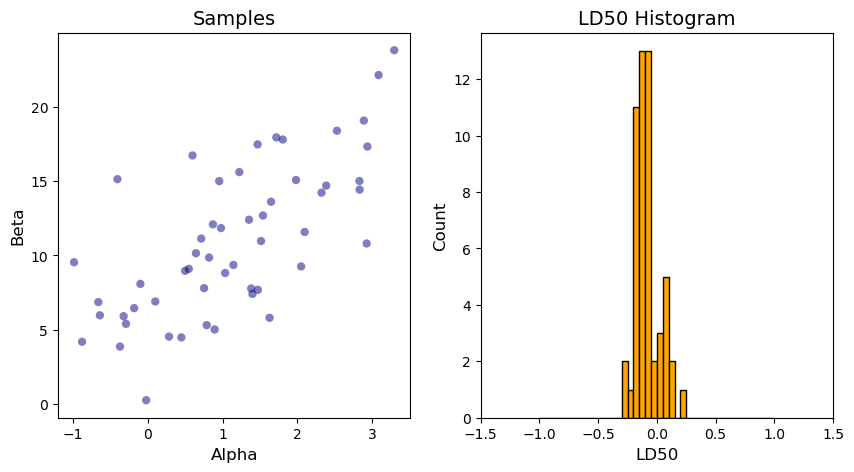

In [10]:
# create the figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the scatter plot on the first axis
axs[0].scatter(samp_acc[:, 0], samp_acc[:, 1], alpha=0.5, color='navy', edgecolors='none')
axs[0].set_xlabel('Alpha', fontsize=12)
axs[0].set_ylabel('Beta', fontsize=12)
axs[0].set_title('Samples', fontsize=14)

# plot the histogram on the second axis
axs[1].hist(samp_ld50, bins=np.arange(-1, 1 + 0.05, 0.05), color='orange', edgecolor='black')
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_xlabel('LD50', fontsize=12)
axs[1].set_ylabel('Count', fontsize=12)
axs[1].set_title('LD50 Histogram', fontsize=14)

plt.show()